### Using color analysis to analyze representation in modeling
The modelling industry is often criticized for upholding a eurocentric beauty standard by continuing to employ predominantly white or light-skinned models; an article from The Guardian (2016) confirms this employment bias by finding that "78.2% of all the models featured in spring 2016’s fashion adverts were white", and this doesn't even include white-passing or other light-skinned minorities.  If this stated bias is represended in Google images top-300, then we can say that the ideal of a model does in fact uphold these eurocentric beauty standards.

#### Dataset:
The dataset consists of the top ~300 images that appear when using google.com image search for the term "model".  While most of the images that popped up were of (human) models, some images pertaining to engineering and mathematics appeared as well.

#### Method:
1) extract faces from the images using 'haarcascade'.  This allows us to:
    a) remove non-human search reults from the data set
    b) some images may contain more than one model; we want to consider these individuals separately
    c) reduce "noise" from non-skintone features like hair, clothing, and background
2) use the library colorgram to determine the average color value per face (to use as an approximation for skin tone)
3) analyse the frequency and distribution of average colors to see what skin tones are represented isn Google images.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import collections
from tqdm import tqdm_notebook

import cv2
import webcolors
import colorgram
from PIL import Image, ImageOps

import tensorflow as tf
from tensorflow import keras
from keras.applications import imagenet_utils  # need this to remove model loading error on my system
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model

# global paths
path_face_classifier = 'C:\\Users\\Julia\\anaconda3\\Lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml'  # location of face detector model
face_cascade = cv2.CascadeClassifier(path_face_classifier)

In [40]:
# create lists of the "model" images and image paths
folder = r'C:\Users\Julia\Desktop\Universiteit_Utrecht\_Block_2_Data_Mining\Exam 2 - Repair Exam March\model'

image_list = []
for file in os.listdir(folder):
    image_list.append(file)
paths_list = [folder + '\\' + file_name for file_name in image_list]

# create dataframe of paths
df = pd.DataFrame()
df['img_path'] = paths_list

In [41]:
print(df)

                                              img_path
0    C:\Users\Julia\Desktop\Universiteit_Utrecht\_B...
1    C:\Users\Julia\Desktop\Universiteit_Utrecht\_B...
2    C:\Users\Julia\Desktop\Universiteit_Utrecht\_B...
3    C:\Users\Julia\Desktop\Universiteit_Utrecht\_B...
4    C:\Users\Julia\Desktop\Universiteit_Utrecht\_B...
..                                                 ...
284  C:\Users\Julia\Desktop\Universiteit_Utrecht\_B...
285  C:\Users\Julia\Desktop\Universiteit_Utrecht\_B...
286  C:\Users\Julia\Desktop\Universiteit_Utrecht\_B...
287  C:\Users\Julia\Desktop\Universiteit_Utrecht\_B...
288  C:\Users\Julia\Desktop\Universiteit_Utrecht\_B...

[289 rows x 1 columns]


In [42]:
# helper funtions for loading images and extracting faces
def load_image_from_path(image_path, target_size=None, color_mode='rgb'):  # from manual
    pil_image = image.load_img(image_path, 
                               target_size=target_size,
                            color_mode=color_mode)
    return image.img_to_array(pil_image)


# find and count faces per image
def find_face_frames(df_pathcol):   # adapted from manual
    '''get face-containing images for all items in dataframe'''
    face_count = []
    face_list = []
    for path in df_pathcol:  
        pre_image = load_image_from_path(path, color_mode='grayscale')   # import from path
        grey_image = np.squeeze(pre_image).astype('uint8')
        
        faces = face_cascade.detectMultiScale(grey_image, scaleFactor = 1.3, minNeighbors = 5)      # apply face detection model 
        n_faces = len(faces)
        
        face_count.append(n_faces)
        face_list.append(faces)
          
    return [face_count, face_list]

In [43]:
# append faces to path dataframe
df_face_count, df_face_list = find_face_frames(df.img_path)
df['number_models'] = df_face_count
df['face_coordinates'] = df_face_list

C:\Users\Julia\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [51]:
# calculate initial statistics
total_images_analysed = len(df.index)
images_with_faces = len(df[df.number_models > 0].index)
total_faces_found = df['number_models'].sum()
print('Number of images analysed: ', total_images_analysed)
print('Number of images with faces: ', images_with_faces, 
      '(',  images_with_faces/total_images_analysed*100 ,'% of images had detectable faces)')
print('Total number of faces found: ', total_faces_found)

Number of images analysed:  289
Number of images with faces:  153 ( 52.94117647058824 % of images had detectable faces)
Total number of faces found:  182


#### NOTE:
Only around 53% of the images found had detectable faces.  This is quite a bit lower than expected when just looking at the search results.  This could partially be due to the poses (if a model is facing sideways, rotated as some unexpected angle, or turned mostly away, their face won't be detected; likewise, some images have a hand in front of the face which may prevent the classifier from recognizing it as a face).

This should not be a problem for our analysis, though.  We can assume that any model is equally likely to be asked to pose in a particular way, so the overall proportion of models' skin colours should not be affected.

In [52]:
# drop images that do not have detectable faces
df = df[df.number_models > 0]


In [73]:
# create new lists with one face per line ==> may be multiple of the same path
paths_list = []
face_corners = []

for row in range(len(df.index)):
    faces_list = df['face_coordinates'].values[row]  # extract lists in face_coordinates 
    for face in faces_list:
        paths_list.append(df['img_path'].values[row])
        face_corners.append(face)

In [90]:
# extract the face images -- adapted from manual
face_list = []
average_colour = []
dominant_colour = []

for i in range(len(paths_list)):
    current_img = load_image_from_path(paths_list[i])    # reloading because we need the colour images to stay colour
    current_img = np.squeeze(current_img).astype('uint8')
    
    current_facebox = face_corners[i] 
    x, y, width, height = current_facebox                 # face box dimensions
    x1, x2, y1, y2 = x, x + width, y, y + height          # turn into 4-coordinate rectangle

    face_img = current_img[y1:y2, x1:x2]                 # extracts face from current frame 
    face_list.append(face_img)

    # get the dominant color and average color per face
    median_r, median_g, median_b = np.median(face_img, axis=(0,1))  # get average colour for the box
    avg_rgb_tuple = (median_r, median_g, median_b) 
    average_colour.append(avg_rgb_tuple)
    
    img = Image.fromarray(face_img.astype(np.uint8))   # convert to PIL image object
    dom_color = colorgram.extract(img, 1)              # extract most dominant colour - adapted from manual
    for i, color in enumerate(dom_color):              # from manual
        rgb = tuple(color.rgb)
        dominant_colour.append(rgb)

average RGB of dominant colour: (177, 144, 127)


Text(0.5, 0.98, 'average RGB of dominant colour')

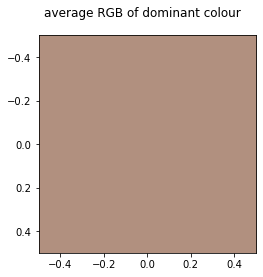

In [126]:
# column averaging tuples:  https://www.geeksforgeeks.org/python-column-mean-in-tuple-list/

# average value of the dominant colours 
avg_dom = tuple([round(sum(ele) / len(dominant_colour)) for ele in zip(*dominant_colour)])
avg_dom_norm = tuple(val/255 for val in avg_dom)  # rescale between 0 and 1
print('average RGB of dominant colour:', avg_dom)

plt.imshow([[avg_dom_norm]])
plt.suptitle('average RGB of dominant colour')

average RGB of average colours: (163, 127, 110)


Text(0.5, 0.98, 'average RGB of average face colour')

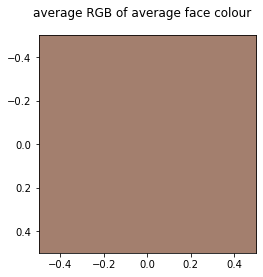

In [127]:
# average value of the average colours 
avg_avg = tuple([round(sum(ele) / len(average_colour)) for ele in zip(*average_colour)])
avg_avg_norm = tuple(val/255 for val in avg_avg)  # rescale between 0 and 1
print('average RGB of average colours:', avg_avg)
plt.imshow([[avg_avg_norm]])
plt.suptitle('average RGB of average face colour')

#### Preliminary Findings:
Both the average colour and average dominant colour are a bit darker than expected.   Though I'm tempted to attribute this to "noise" from background, this shouldn't be the case:  1) we've already cropped the pictures to contain only the face and its bounding box (no additional buffers), and 2) the photographs are on a multitude of backgrounds, so you'd expect the light and dark backgrounds to somewhat cancel each other out.

The only way to make sense of these averages is to compare them with the values for individual model faces.  To do this, we will plot the RGB values in 3D.

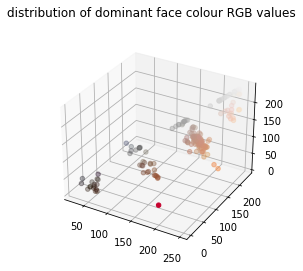

In [144]:
# colour plot technique from here: https://liorben-david.medium.com/visualizing-the-color-spaces-of-images-with-python-and-matplotlib-79af1577e6cc
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

c = tuple(tuple(val/255 for val in img) for img in dominant_colour)  # rescale all colour tuples from 0 to 1

x = list(zip(*dominant_colour))[0]
y = list(zip(*dominant_colour))[1]
z = list(zip(*dominant_colour))[2]
ax.scatter(x, y, z, c = c)
plt.suptitle('distribution of dominant face colour RGB values')
plt.show()

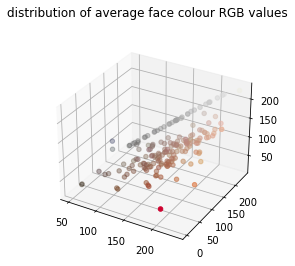

In [145]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

c = tuple(tuple(val/255 for val in img) for img in average_colour)  # rescale all colour tuples from 0 to 1

x = list(zip(*average_colour))[0]
y = list(zip(*average_colour))[1]
z = list(zip(*average_colour))[2]
ax.scatter(x, y, z, c = c)
plt.suptitle('distribution of average face colour RGB values')
plt.show()

### Conclusion
Though the average face colour graph shows a fairly even distribution (though still tending to lighter tones), the dominant colour analysis provides a much clearer overview of the models photographed.

Looking at the dominant face colour distribution its clear that models fall into 4 skin-tone categories, and that medium-light skin tone is by far the most prevalent skin tone represented in photographs of models (and thus in modeling).  What is also interesting, though, is how many black and white images there were in the data set.  It's likely that these black and white images (clustered in such a way that they heavily overlap the darkest skin tone category) may have contributed to the overall "darkening" of the single average values.

This analysis of google image search results demonstrates that light-skinned models are more prevalent in photographic representation, and because the nature of the modelling job is to be photographed, indicates that light skinned models are more likely to be photographed/featured, corroborating existing bias statistics.  Since real-world statistics are so closely mirrored in google search results, it lends credibility to the notion that analysing google images can give us insight into society's perceptions as a whole.